# CISC372 Project - Stock Trend Prediction based on Sentimen Analysis

## Proposed approach - Lexicon based analysis

In [2]:
# Install dependencies
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import package and data

In [3]:
# Import packages
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [5]:
# Integrate the stock close data to the news
df = pd.read_csv('./dataset/Stock_Headlines.csv',parse_dates=[0])
stock_data = pd.read_csv('./dataset/DJIA_table.csv',parse_dates=[0])
stock_data.iloc[:] = stock_data.iloc[::-1].values
df["Close"] = stock_data.Close
df.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11734.320312
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11782.349609
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11642.469727


### Clean data

In [6]:
# Check if there is missing value
df.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
Close    0
dtype: int64

In [7]:
# Replace missing value with whitespace as they are headlines
df = df.replace(np.nan, ' ', regex=True)
df.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    0
Top24    0
Top25    0
Close    0
dtype: int64

In [8]:
# Remove useless character
df = df.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
df.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Close
0,2008-08-08,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,...,Al-Qaeda Faces Islamist Backlash',Condoleezza Rice: The US would not act to prev...,This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge,11734.320312
1,2008-08-11,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked',What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,...,"Do not believe TV, neither Russian nor Georgia...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...,11782.349609
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation',If we had no sexual harassment we would have n...,Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,...,Why Russias response to Georgia was right',Gorbachev accuses U.S. of making a serious blu...,"Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...,11642.469727


### Perform sentiment analysis by VADER

In [9]:
# Download lexicon and initialize the analyzer
nltk.download('vader_lexicon')
analyzer = sia()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Get the name of the headline columns
cols = list()
for i in range(1,26):
    col = (f"Top{i}")
    cols.append(col)

# Calculate the VANDER score and extract the compound column
for col in cols:
    df[col] = df[col].astype(str) # Make sure data is treated as a string
    df[col+'_comp']= df[col].apply(lambda x:analyzer.polarity_scores(x)['compound'])
    print(f"{col} vanderized")

Top1 vanderized
Top2 vanderized
Top3 vanderized
Top4 vanderized
Top5 vanderized
Top6 vanderized
Top7 vanderized
Top8 vanderized
Top9 vanderized
Top10 vanderized
Top11 vanderized
Top12 vanderized
Top13 vanderized
Top14 vanderized
Top15 vanderized
Top16 vanderized
Top17 vanderized
Top18 vanderized
Top19 vanderized
Top20 vanderized
Top21 vanderized
Top22 vanderized
Top23 vanderized
Top24 vanderized
Top25 vanderized


In [11]:
# Drop the text columns as we no longer need them
df = df.drop(cols,axis=1)

In [12]:
# Get compound columns
vander_cols = list()
for col in cols:
    vander_col = f"{col}_comp"
    vander_cols.append(vander_col)

weighted_comp=list()
max_comp = list()
min_comp = list()

for i in range(len(df)):
    temp = df.loc[i, vander_cols].to_list()
    weighted_comp.append(np.average(temp))
    max_comp.append(max(temp))
    min_comp.append(min(temp))

df['compound_mean'] = weighted_comp
df['compound_max'] = max_comp
df['compound_min'] = min_comp

df = df.drop(vander_cols,axis=1)

In [13]:
df.tail(20)

,Date,Label,Close,compound_mean,compound_max,compound_min
1969,2016-06-06,1,17920.330078,-0.257180,0.7184,-0.9081
1970,2016-06-07,1,17938.279297,-0.120532,0.5106,-0.7650
1971,2016-06-08,1,18005.050781,-0.091440,0.8720,-0.9081
1972,2016-06-09,0,17985.189453,-0.088084,0.8442,-0.9313
1973,2016-06-10,0,17865.339844,-0.132216,0.5613,-0.9477
1974,2016-06-13,0,17732.480469,-0.155468,0.8360,-0.9081
1975,2016-06-14,0,17674.820312,-0.152276,0.7269,-0.7906
1976,2016-06-15,0,17640.169922,-0.303500,0.4019,-0.8979
1977,2016-06-16,1,17733.099609,-0.270616,0.5413,-0.9413
1978,2016-06-17,0,17675.160156,-0.295452,0.5859,-0.8720


### Visualize the data

Text(0, 0.5, 'Price')

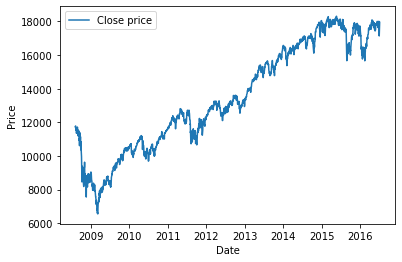

In [14]:
# Visualization of the close price
plt.plot(df.Date,df.Close)
plt.legend(['Close price'],loc = 2)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0, 0.5, 'VADER compound score')

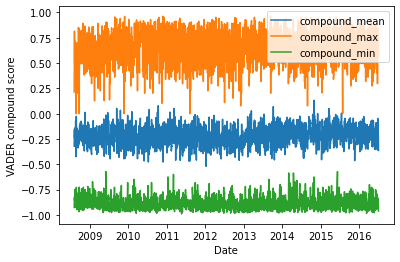

In [15]:
# Visualization of the score
plt.plot(df.Date,df.compound_mean)
plt.plot(df.Date,df.compound_max)
plt.plot(df.Date,df.compound_min)
plt.legend(['compound_mean','compound_max','compound_min'],loc = 1)
plt.xlabel('Date')
plt.ylabel('VADER compound score')

### Split the data

In [16]:
# Split train and test set

split_rate = int(len(df)*0.8)

df_split = df.drop(['Date','Close','Label'],axis=1)

df_split
X_train = df_split.iloc[:split_rate]
y_train = df.Close.iloc[:split_rate]
X_test = df_split.iloc[split_rate:]
y_test = df.Close.iloc[split_rate:]


In [17]:
# Cross validation fold
cv = TimeSeriesSplit(n_splits=8)

### Train the regression model (Random Forest)

In [18]:
# Use RMSE as the evaluation
eval = make_scorer(mse, squared = False)

In [20]:
rf_param = {'regressor__n_estimators': [10, 100, 300],
            'regressor__max_depth': [10, 20, 30, 40],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1 , 2, 3],
            'regressor__max_features': ["auto", 'sqrt']}
rf = RandomForestRegressor()
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe_rf,
                          param_grid = rf_param,
                          scoring = eval,
                          cv = cv,
                          n_jobs=4,
                          verbose=5
                         )
gridsearch_rf.fit(X_train, y_train)

Fitting 8 folds for each of 216 candidates, totalling 1728 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'regressor__max_depth': [10, 20, 30, 40],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__min_samples_leaf': [1, 2, 3],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [10, 100, 300]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=5)

In [21]:
# Check RMSE value
rf_best = gridsearch_rf.best_estimator_
cv_score_rf = cross_val_score(rf_best, X_train, y_train, cv=cv, scoring = eval)
print(f'The RMSE value for Random Forest is {np.mean(cv_score_rf)}')

The RMSE value for Random Forest is 2817.7548446771625


### Train the model (XGBoost)

In [22]:
xgb_param = {'regressor__lambda': list(np.arange(1,10, 1)), #L2 regularisation
             'regressor__alpha': list(np.arange(1,10, 1)),  #L1 regularisation
             'regressor__subsample': [0.5,0.8],
             'regressor__booster': ['gbtree','gblinear'],
             'regressor__eta': [0.05,0.1],
            }
xgb = XGBRegressor( feature_selector='shuffle', objective='reg:squarederror')

pipe_xgb = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe_xgb,
                          param_grid = xgb_param,
                          cv = cv,
                          scoring = eval,
                          n_jobs=4,
                          verbose=5
                         )
gridsearch_xgb.fit(X_train, y_train)

Fitting 8 folds for each of 648 candidates, totalling 5184 fits
[20:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feature_selector" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     featur...
                                                     n_jobs=N

In [23]:
# Check RMSE value
xgb_best = gridsearch_xgb.best_estimator_
cv_score_xgb = cross_val_score(xgb_best, X_train, y_train, cv=cv, scoring = eval)
print(f'The RMSE value for XGBoost is {np.mean(cv_score_xgb)}')


[20:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feature_selector" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feature_selector" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:30:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feature_selector" } might not be 

### Add previous data as baseline for the model to check back

In [24]:
# Add previous data as baseline
df_prev = df.copy()
df_prev['Close_prev_2'] = df_prev['Close'].shift(2)
df_prev['compound_mean_prev_1'] = df_prev['compound_mean'].shift(1)
df_prev['Close_prev_1'] = df_prev['Close'].shift(1)
df_prev['compound_mean_prev_2'] = df_prev['compound_mean'].shift(2)
df_prev['compound_max_prev_1'] = df_prev['compound_max'].shift(1)
df_prev['compound_max_prev_2'] = df_prev['compound_max'].shift(2)
df_prev['compound_min_prev_1'] = df_prev['compound_min'].shift(1)
df_prev['compound_min_prev_2'] = df_prev['compound_min'].shift(2)
df_prev

,Date,Label,Close,compound_mean,compound_max,compound_min,Close_prev_2,compound_mean_prev_1,Close_prev_1,compound_mean_prev_2,compound_max_prev_1,compound_max_prev_2,compound_min_prev_1,compound_min_prev_2
0,2008-08-08,0,11734.320312,-0.320396,0.2144,-0.9260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-08-11,1,11782.349609,-0.154188,0.8156,-0.8271,NaN,-0.320396,11734.320312,NaN,0.2144,NaN,-0.9260,NaN
2,2008-08-12,0,11642.469727,-0.241532,0.5423,-0.8591,11734.320312,-0.154188,11782.349609,-0.320396,0.8156,0.2144,-0.8271,-0.9260
3,2008-08-13,0,11532.959961,-0.141844,0.5106,-0.8074,11782.349609,-0.241532,11642.469727,-0.154188,0.5423,0.8156,-0.8591,-0.8271
4,2008-08-14,1,11615.929688,-0.178700,0.7177,-0.8689,11642.469727,-0.141844,11532.959961,-0.241532,0.5106,0.5423,-0.8074,-0.8591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,17140.240234,-0.142656,0.8442,-0.8720,18011.070312,-0.046832,17400.750000,-0.158004,0.5598,0.7964,-0.8316,-0.9042
1985,2016-06-28,1,17409.720703,-0.067312,0.8316,-0.8818,17400.750000,-0.142656,17140.240234,-0.046832,0.8442,0.5598,-0.8720,-0.8316
1986,2016-06-29,1,17694.679688,-0.209956,0.7783,-0.9211,17140.240234,-0.067312,17409.720703,-0.142656,0.8316,0.8442,-0.8818,-0.8720
1987,2016-06-30,1,17929.990234,-0.280596,0.7351,-0.9578,17409.720703,-0.209956,17694.679688,-0.067312,0.7783,0.8316,-0.9211,-0.8818


In [25]:
# Remove missing data
df_prev.isnull().sum()
df_prev = df_prev.fillna(method="backfill")
df_prev

,Date,Label,Close,compound_mean,compound_max,compound_min,Close_prev_2,compound_mean_prev_1,Close_prev_1,compound_mean_prev_2,compound_max_prev_1,compound_max_prev_2,compound_min_prev_1,compound_min_prev_2
0,2008-08-08,0,11734.320312,-0.320396,0.2144,-0.9260,11734.320312,-0.320396,11734.320312,-0.320396,0.2144,0.2144,-0.9260,-0.9260
1,2008-08-11,1,11782.349609,-0.154188,0.8156,-0.8271,11734.320312,-0.320396,11734.320312,-0.320396,0.2144,0.2144,-0.9260,-0.9260
2,2008-08-12,0,11642.469727,-0.241532,0.5423,-0.8591,11734.320312,-0.154188,11782.349609,-0.320396,0.8156,0.2144,-0.8271,-0.9260
3,2008-08-13,0,11532.959961,-0.141844,0.5106,-0.8074,11782.349609,-0.241532,11642.469727,-0.154188,0.5423,0.8156,-0.8591,-0.8271
4,2008-08-14,1,11615.929688,-0.178700,0.7177,-0.8689,11642.469727,-0.141844,11532.959961,-0.241532,0.5106,0.5423,-0.8074,-0.8591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,0,17140.240234,-0.142656,0.8442,-0.8720,18011.070312,-0.046832,17400.750000,-0.158004,0.5598,0.7964,-0.8316,-0.9042
1985,2016-06-28,1,17409.720703,-0.067312,0.8316,-0.8818,17400.750000,-0.142656,17140.240234,-0.046832,0.8442,0.5598,-0.8720,-0.8316
1986,2016-06-29,1,17694.679688,-0.209956,0.7783,-0.9211,17140.240234,-0.067312,17409.720703,-0.142656,0.8316,0.8442,-0.8818,-0.8720
1987,2016-06-30,1,17929.990234,-0.280596,0.7351,-0.9578,17409.720703,-0.209956,17694.679688,-0.067312,0.7783,0.8316,-0.9211,-0.8818


### Split the data

In [26]:
# Split train and test set

df_split_p = df_prev.drop(['Date','Label'],axis=1)

X_train_p = df_split_p.iloc[:split_rate]
y_train_p = df_split_p.Close.iloc[:split_rate]
X_test_p = df_split_p.iloc[split_rate:]
y_test_p = df_split_p.Close.iloc[split_rate:]
df_split_p

,Close,compound_mean,compound_max,compound_min,Close_prev_2,compound_mean_prev_1,Close_prev_1,compound_mean_prev_2,compound_max_prev_1,compound_max_prev_2,compound_min_prev_1,compound_min_prev_2
0,11734.320312,-0.320396,0.2144,-0.9260,11734.320312,-0.320396,11734.320312,-0.320396,0.2144,0.2144,-0.9260,-0.9260
1,11782.349609,-0.154188,0.8156,-0.8271,11734.320312,-0.320396,11734.320312,-0.320396,0.2144,0.2144,-0.9260,-0.9260
2,11642.469727,-0.241532,0.5423,-0.8591,11734.320312,-0.154188,11782.349609,-0.320396,0.8156,0.2144,-0.8271,-0.9260
3,11532.959961,-0.141844,0.5106,-0.8074,11782.349609,-0.241532,11642.469727,-0.154188,0.5423,0.8156,-0.8591,-0.8271
4,11615.929688,-0.178700,0.7177,-0.8689,11642.469727,-0.141844,11532.959961,-0.241532,0.5106,0.5423,-0.8074,-0.8591
...,...,...,...,...,...,...,...,...,...,...,...,...
1984,17140.240234,-0.142656,0.8442,-0.8720,18011.070312,-0.046832,17400.750000,-0.158004,0.5598,0.7964,-0.8316,-0.9042
1985,17409.720703,-0.067312,0.8316,-0.8818,17400.750000,-0.142656,17140.240234,-0.046832,0.8442,0.5598,-0.8720,-0.8316
1986,17694.679688,-0.209956,0.7783,-0.9211,17140.240234,-0.067312,17409.720703,-0.142656,0.8316,0.8442,-0.8818,-0.8720
1987,17929.990234,-0.280596,0.7351,-0.9578,17409.720703,-0.209956,17694.679688,-0.067312,0.7783,0.8316,-0.9211,-0.8818


### Train model with previous data provided (Random Forest)

In [27]:
pipe_rf_p = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', rf)])
p_gridsearch_rf = GridSearchCV(estimator=pipe_rf_p,
                          param_grid = rf_param,
                          scoring = eval,
                          cv = cv,
                          n_jobs=4,
                          verbose=5
                         )
p_gridsearch_rf.fit(X_train_p, y_train_p)

Fitting 8 folds for each of 216 candidates, totalling 1728 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'regressor__max_depth': [10, 20, 30, 40],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__min_samples_leaf': [1, 2, 3],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [10, 100, 300]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=5)

In [28]:
# Check RMSE value
p_rf_best = p_gridsearch_rf.best_estimator_
cv_score_rf_p = cross_val_score(p_rf_best, X_train_p, y_train_p, cv=cv, scoring = eval)
print(f'The RMSE value for Random Forest with previous data is {np.mean(cv_score_rf_p)}')

The RMSE value for Random Forest with previous data is 580.0456082669626


### Train model with previous data provided (XGBoost)


In [29]:
p_gridsearch_xgb = GridSearchCV(estimator=pipe_xgb,
                          param_grid = xgb_param,
                          cv = cv,
                          scoring = eval,
                          n_jobs=4,
                          verbose=5
                         )
p_gridsearch_xgb.fit(X_train_p, y_train_p)

Fitting 8 folds for each of 648 candidates, totalling 5184 fits
[20:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     featur...
                                                     n_jobs=N

In [30]:
# Check RMSE value
p_xgb_best = p_gridsearch_xgb.best_estimator_
cv_score_xgb_p = cross_val_score(p_xgb_best, X_train_p, y_train_p, cv=cv, scoring = eval)
print(f'The RMSE value for XGBoost with previous data is {np.mean(cv_score_xgb_p)}')


[20:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:33:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "subsample" } might not be used.

  This could b

### Parallel comparison 

In [48]:
# Create RMSE comparison table
RMSE_comparison = pd.DataFrame(pd.DataFrame(columns=['rf','xgb','rf_p','xgb_p']),index = ['RMSE_score'])
rmse_score = [np.mean(cv_score_rf),np.mean(cv_score_xgb),np.mean(cv_score_rf_p),np.mean(cv_score_xgb_p)]
RMSE_comparison.loc['RMSE_score'] = rmse_score
RMSE_comparison

,rf,xgb,rf_p,xgb_p
RMSE_score,2817.754845,2872.498832,580.045608,44.927675


In [32]:
comparison = pd.DataFrame(pd.DataFrame(columns=['y','xgb_best','rf_best','xgb_p_best','rf_p_best']))
comparison['y'] = y_test
comparison['xgb_best'] = xgb_best.predict(X_test)
comparison['rf_best'] = rf_best.predict(X_test)
comparison['xgb_p_best'] = p_xgb_best.predict(X_test_p)
comparison['rf_p_best'] = p_rf_best.predict(X_test_p)

comparison

,y,xgb_best,rf_best,xgb_p_best,rf_p_best
1591,17912.619141,11242.479492,11699.649156,13733.660156,17408.253535
1592,17900.099609,12599.195312,13366.870557,13729.527344,16822.414887
1593,17958.789062,13617.332031,13718.921346,13703.405273,16658.238016
1594,17852.480469,12184.798828,13129.117646,13762.180664,17336.750420
1595,17801.199219,12049.037109,13508.055982,13752.288086,17507.568303
...,...,...,...,...,...
1984,17140.240234,11936.913086,13491.305709,13682.177734,17445.691612
1985,17409.720703,12001.260742,10861.260156,13641.910156,17300.105238
1986,17694.679688,12096.337891,10807.145333,13672.190430,17392.793221
1987,17929.990234,12291.897461,13511.849024,13726.597656,17364.602106
